# <b> Titanic Machine Learning from Disaster </b>
- source: https://www.kaggle.com/competitions/titanic/overview

## <b> History </b>
"Titanic, launched on May 31, 1911, and set sail on its maiden voyage from Southampton on April 10, 1912, with 2,240 passengers and crew on board. On April 15, 1912, after striking an iceberg, Titanic broke apart and sank to the bottom of the ocean, taking with it the lives of more than 1,500 passengers and crew."
- source: https://www.noaa.gov/gc-international-section/rms-titanic-history-and-significance

## 1.0 Data Dictionary
- source: https://www.kaggle.com/competitions/titanic/data

| Variable | Definition                                  | Key                                            |
| -------- | ------------------------------------------- | ---------------------------------------------- |
| survival | Survival                                    | 0 = No, 1 = Yes                                |
| pclass   | Ticket class                                | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| sex      | Sex                                         |                                                |
| Age      | Age in years                                |                                                |
| sibsp    | \# of siblings / spouses aboard the Titanic |                                                |
| parch    | \# of parents / children aboard the Titanic |                                                |
| ticket   | Ticket number                               |                                                |
| fare     | Passenger fare                              |                                                |
| cabin    | Cabin number                                |                                                |
| embarked | Port of Embarkation                         | C = Cherbourg, Q = Queenstown, S = Southampton |

<b> Variable Notes </b>

- <b> pclass </b>: A proxy for socio-economic status (SES)
   * 1st = Upper
   * 2nd = Middle
   * 3rd = Lower
   
- <b> age </b>: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

- <b> sibsp </b>: The dataset defines family relations in this way...
- <b> Sibling </b> = brother, sister, stepbrother, stepsister
- <b> Spouse </b> = husband, wife (mistresses and fiancés were ignored)

- <b> parch </b>: The dataset defines family relations in this way...
- <b> Parent </b> = mother, father
- <b> Child </b> = daughter, son, stepdaughter, stepson
- Some children travelled only with a nanny, therefore parch=0 for them.

## 1.1 Load Packages

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import matplotlib.pyplot as plt # visualizations/graphs
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

## 1.2 Load Data

In [3]:
# load training dataset
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
# load test dataset
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
total_data = pd.concat([train_data, test_data], axis=0, sort=False,  ignore_index=True)

## 1.3 EDA - Exploratory Data Analysis

### Check data - train_data / test_data / total_data

In [4]:
train_data.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [5]:
test_data.head(1)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q


In [6]:
total_data.tail(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1308,1309,NaN,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
print('--------------------------------------------')
print('Missing values in dataset i.e. NaN values')
print('--------------------------------------------')
values_missing = round(train_data.isna().sum())
perc_missing = round(train_data.isna().sum() / train_data.shape[0]*100, 2)

# sorted percentages of missing
df_missing = pd.DataFrame(values_missing, columns=['values_missing']).sort_values('values_missing', ascending=False)
df_missing['perc_nan'] = perc_missing
df_missing

--------------------------------------------
Missing values in dataset i.e. NaN values
--------------------------------------------


,values_missing,perc_nan
Cabin,687,77.10
Age,177,19.87
Embarked,2,0.22
PassengerId,0,0.00
Survived,0,0.00
Pclass,0,0.00
Name,0,0.00
Sex,0,0.00
SibSp,0,0.00
Parch,0,0.00


In [9]:
df_survived = train_data[['Survived', 'Sex']].groupby('Sex').sum()
df_survived['% of total'] = df_survived.apply(lambda x: round(x/df_survived['Survived'].sum()*100,2))
df_survived

,Survived,% of total
Sex,,
female,233,68.13
male,109,31.87


In [10]:
train_data.groupby('Survived')['PassengerId'].count()

Survived
0    549
1    342
Name: PassengerId, dtype: int64

In [11]:
pd.crosstab(train_data['Sex'], train_data['Survived'])

Survived,0,1
Sex,,
female,81,233
male,468,109


In [12]:
pd.crosstab(train_data['Sex'], train_data['Survived'], normalize='index').round(2)*100

Survived,0,1
Sex,,
female,26.0,74.0
male,81.0,19.0


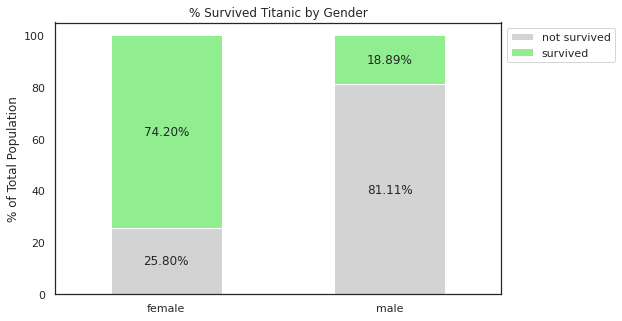

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook") # paper, poster
sns.set_style("white")

# set runtime configuration 
# source: https://matplotlib.org/stable/tutorials/introductory/customizing.html
plt.rcParams['figure.figsize'] = (8, 5)

# define axis
ax = (pd.crosstab(train_data['Sex'], 
                  train_data['Survived'], 
                  normalize='index')*100) \
                  .round(2).plot.bar(stacked=True, 
                  title='% Survived Titanic by Gender', 
                  color=['lightgrey', 'lightgreen'])

# annotate the barchart labels in center
ax.bar_label(ax.containers[0], label_type='center', fmt='%.2f%%') 
ax.bar_label(ax.containers[1], label_type='center', fmt='%.2f%%')

# set the x and y labels
plt.xlabel("")
plt.ylabel("% of Total Population")

# set the legend
plt.legend(loc = 'best',
           labels={'not survived':1, 'survived':0}, 
           bbox_to_anchor=(1, 1))

# set the rotation of the x labels (female, male)
for label in ax.get_xticklabels():
    label.set_rotation(0) 

In [14]:
# check the missing values for age row-wise to validate
df_missing = train_data[train_data['Age'] != train_data['Age']]
df_missing

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


In [15]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


## Feature Engineering
- Feature: Title 
-source: https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/

In [16]:
import regex as re

def get_title(name):
    """
    Use a regular expression to search for a title.  Titles always consist of
    capital and lowercase letters, and end with a period.
    Takes a name as input and returns the title string as output
    """
    title_search = re.search('([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

In [17]:
total_data["Title"] = total_data["Name"].apply(get_title)  
#We dropped "Name" earlier. So, we use original data.
total_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [18]:
# see all unique names in training data
unique_titles = total_data["Title"].unique()
print(unique_titles)

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer' 'Dona']


In [19]:
# show the counts of the different titles extracted from the names
# note: validate count to check if binning features could be useful 
total_data.groupby('Title')['PassengerId'].count().sort_values(ascending=False)

Title
Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Mlle          2
Ms            2
Major         2
Mme           1
Capt          1
Lady          1
Jonkheer      1
Dona          1
Don           1
Countess      1
Sir           1
Name: PassengerId, dtype: int64

- source: https://towardsdatascience.com/kaggles-titanic-competition-in-10-minutes-part-iii-a492a1a1604f

It seems that we have four major groups: ‘Mr’, ‘Mrs’, ‘Miss’, ‘Master’, and others. However, before grouping all the other titles as Others, we need to take care of the French titles. We need to convert them to their corresponding English titles with the following code:

In [20]:
def replace_title(my_key):
    # dictionary with title and replacement title
    title_dict = {'Dr': 'Other', 
             'Rev': 'Other', 
             'Major': 'Other', 
             'Col': 'Other', 
             'Mlle': 'Miss', 
             'Mme': 'Mrs', 
             'Ms': 'Miss', 
             'Capt': 'Other', 
             'Lady': 'Other', 
             'Jonkheer': 'Other', 
             'Dona':'Mrs',
             'Don': 'Mr',
             'Countess': 'Other', 
             'Sir': 'Other'}
    
    try:
        for key, value in title_dict.items():
            return title_dict[my_key]
    except:
        return my_key

In [21]:
# apply function to replace the infrequent titles
# change title to 'Other' or replace french title by english
total_data['Title_adj'] = total_data['Title'].apply(lambda x: replace_title(x))

In [22]:
# validate if 'Title_adj' column was added correctly
total_data[['Title', 'Title_adj']] \
[(total_data['Title_adj'] != total_data['Title'])].sort_values(by='Title')

,Title,Title_adj
745,Capt,Other
647,Col,Other
1093,Col,Other
1022,Col,Other
694,Col,Other
759,Countess,Other
30,Don,Mr
1305,Dona,Mrs
796,Dr,Other
766,Dr,Other


In [23]:
# show the counts of the different titles extracted from the names
# note: validate count to check if binning features could be useful 
print(total_data.groupby('Title_adj')['PassengerId'].count().sort_values(ascending=False))

print('--------------------')
print('How many survived:')
print('--------------------')
print(total_data.groupby('Title_adj')['Survived'].sum().sort_values(ascending=False))

Title_adj
Mr        758
Miss      264
Mrs       199
Master     61
Other      27
Name: PassengerId, dtype: int64
--------------------
How many survived:
--------------------
Title_adj
Miss      130.0
Mrs       100.0
Mr         81.0
Master     23.0
Other       8.0
Name: Survived, dtype: float64


In [24]:
train_data["Title"] = train_data["Name"].apply(get_title)  
train_data['Title_adj'] = train_data['Title'].apply(lambda x: replace_title(x))

test_data["Title"] = test_data["Name"].apply(get_title)  
test_data['Title_adj'] = test_data['Title'].apply(lambda x: replace_title(x))

In [25]:
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Title_adj
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Rev,Other
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Miss,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,Miss,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Mr,Mr


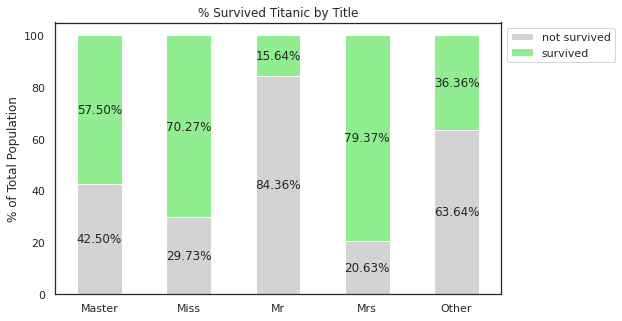

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook") # paper, poster
sns.set_style("white")

# set runtime configuration 
# source: https://matplotlib.org/stable/tutorials/introductory/customizing.html
plt.rcParams['figure.figsize'] = (8, 5)

# define axis
ax = (pd.crosstab(train_data['Title_adj'], 
                  train_data['Survived'], 
                  normalize='index')*100) \
                  .round(2).plot.bar(stacked=True, 
                  title='% Survived Titanic by Title', 
                  color=['lightgrey', 'lightgreen'])

# annotate the barchart labels in center
ax.bar_label(ax.containers[0], label_type='center', fmt='%.2f%%') 
ax.bar_label(ax.containers[1], label_type='center', fmt='%.2f%%')

# set the x and y labels
plt.xlabel("")
plt.ylabel("% of Total Population")

# set the legend
plt.legend(loc = 'best',
           labels={'not survived':1, 'survived':0}, 
           bbox_to_anchor=(1, 1))

# set the rotation of the x labels (female, male)
for label in ax.get_xticklabels():
    label.set_rotation(0) 

## Model 1 - RandomForestClassifier
- note: score 0.77511

In [27]:
# define list of features e.g. independent variables
features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Title_adj', 'Embarked']

# create dummy variables from features of training set
X = pd.get_dummies(train_data[features])

# define dependent variable
y = train_data['Survived']

In [28]:
from sklearn.model_selection import train_test_split
# split training set into a train/test set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33, 
                                                    random_state = 42)

In [29]:
%%time
# Gridsearch
param_grid = { 
    'n_estimators': [100, 200, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1, 2, 3, 4, 5, 6, 7, 8],
    'criterion' :['gini', 'entropy']
}

rfc = RandomForestClassifier(random_state=100)
CV_rfc = GridSearchCV(estimator = rfc, param_grid = param_grid, cv = 5)
CV_rfc.fit(X_train, y_train)

CPU times: user 8min 51s, sys: 3.52 s, total: 8min 55s
Wall time: 8min 55s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=100),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 500, 1000]})

In [30]:
# show optimal parameters of gridsearch
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'auto',
 'n_estimators': 1000}

In [31]:
# define dependent variable
y = train_data["Survived"]

# define list of features e.g. independent variables
features = ["Pclass", "Sex", "SibSp", "Parch", "Title_adj", 'Embarked']

# create dummy variables from features of training set
X = pd.get_dummies(train_data[features])

# create dummy variables from features of test set
X_test = pd.get_dummies(test_data[features])

# define the model with the hyper-parameters
model = RandomForestClassifier(n_estimators=1000, 
                               max_depth=4, 
                               random_state=1, 
                               criterion='gini',
                               max_features='auto')

# fit the model
model.fit(X, y)

# make the predictions
predictions = model.predict(X_test)

# create a pandas dataframe with the output of the predictions
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})

# output to .csv file the prediction
output.to_csv('submission.csv', index=False)

# print user message that submission was succesfull 
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [32]:
# show output prediction of test_data of passengerId survived or not
output

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [33]:
# show prediction how many survived (=1) and did not survive (=0)
total_count = output['PassengerId'].count()
pd.crosstab(total_count , output['Survived'])

Survived,0,1
row_0,,
418,254,164
